In [1]:
# Dependencies

# Standard modules
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import nltk.stem

# Setup matpltlib visualization
%matplotlib inline

In [2]:
# Constants

# Path to words dataset .csv file
WORDS_PATH = 'data/database/words.csv'

In [3]:
# Load words dataset
words = pd.read_csv(WORDS_PATH, dtype={
    'tweet': np.unicode_,
    'index': np.int,
    'text': np.unicode_,
    'pos': np.unicode_,
    'conf': np.float
})

# Show few lines of the dataset
words.head()

,tweet,index,text,pos,conf
0,1204199429177315329,0,RT,~,0.9979
1,1204199429177315329,1,@unwomenjordan,@,0.9991
2,1204199429177315329,2,:,~,0.9630
3,1204199429177315329,3,From,P,0.9991
4,1204199429177315329,4,the,D,0.9975


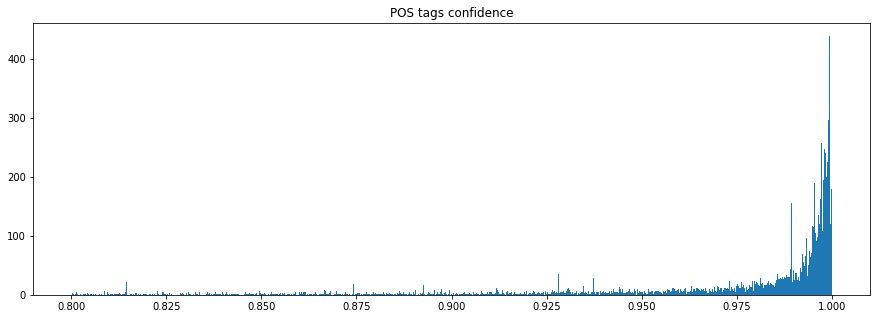

In [4]:
# Show distribution of confidence for POS tags
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.hist(words.conf, bins=1000, range=(0.8, 1.0))
_ = ax.set_title('POS tags confidence')
_ = plt.plot()

In [5]:
# Dataset subset

# Get only verbs (V), adjectives (A), common nouns (N)
words = words[words.pos.isin(['V', 'A', 'N'])]

# Get only words with acceptable confidence (over 0.925)
words = words[words.conf > 0.925]

# Show dataset shape
print('Dataset shape: {:s}'.format(str(words.shape)), end='\n')

# Show ordered dataset
words.sort_values(by=['tweet', 'index'], inplace=True)
words.head()

Dataset shape: (3256, 5)


,tweet,index,text,pos,conf
10,1204199429177315329,10,equal,A,0.9980
11,1204199429177315329,11,work,N,0.9960
16,1204199429177315329,16,leaders,N,0.9717
19,1204199429177315329,19,engage,V,0.9532
27,1204205766342840336,2,are,V,0.9986


In [6]:
# Define Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# Define post processing function
def post_process(word):
    """
    Post processing function, to be applied after words tokenization and POS tagging
    It lowers and stems a given word
    """
    word = word.lower()
    word = stemmer.stem(word)
    return word

In [7]:
# Post process words in dataset
words.text = words.text.map(post_process)
words.head()

,tweet,index,text,pos,conf
10,1204199429177315329,10,equal,A,0.9980
11,1204199429177315329,11,work,N,0.9960
16,1204199429177315329,16,leader,N,0.9717
19,1204199429177315329,19,engag,V,0.9532
27,1204205766342840336,2,are,V,0.9986


In [8]:
# Map each unique word to a number (word-to-index) and vice versa (index-to-word)
w2i, i2w = dict(), dict()
for index, word in enumerate(set(words.text)):
    w2i[word] = index
    i2w[index] = word

In [9]:
# Create a words dataframe without some useless fields
words_ = words[['tweet', 'index', 'text', 'pos']]

# Build relationships: join each word with each word in the same tweet
edges = pd.merge(words_, words_, on='tweet')
edges.head()

,tweet,index_x,text_x,pos_x,index_y,text_y,pos_y
0,1204199429177315329,10,equal,A,10,equal,A
1,1204199429177315329,10,equal,A,11,work,N
2,1204199429177315329,10,equal,A,16,leader,N
3,1204199429177315329,10,equal,A,19,engag,V
4,1204199429177315329,11,work,N,10,equal,A


In [10]:
# Remove matches between the same word
edges = edges[edges.index_x != edges.index_y]
edges.head()

,tweet,index_x,text_x,pos_x,index_y,text_y,pos_y
1,1204199429177315329,10,equal,A,11,work,N
2,1204199429177315329,10,equal,A,16,leader,N
3,1204199429177315329,10,equal,A,19,engag,V
4,1204199429177315329,11,work,N,10,equal,A
6,1204199429177315329,11,work,N,16,leader,N


In [11]:
# Count how many times the same word matches have been found
edges = edges.groupby(['text_x', 'text_y']).size().reset_index(name='counts')
edges.head()

,text_x,text_y,counts
0,#amend,divis,1
1,#amend,ha,1
2,#amend,isn't,1
3,#amend,outrag,1
4,#amend,photo,1


In [12]:
# Map each word to a numeric index
edges['number_x'] = edges.text_x.map(w2i)
edges['number_y'] = edges.text_y.map(w2i)
edges.head()

,text_x,text_y,counts,number_x,number_y
0,#amend,divis,1,392,1032
1,#amend,ha,1,392,422
2,#amend,isn't,1,392,191
3,#amend,outrag,1,392,14
4,#amend,photo,1,392,68


In [15]:
# Build adjacency matrix

# Define set of available words
words = list(w2i.keys())
# Get number of words
n = len(words)

# Initialize adjacency matrix
X = np.zeros(shape=(n, n), dtype=np.int)

# Loop through each edge in order to fill adjacency matrix
for i, edge in edges.iterrows():
    # Fill each cell with counts greater than zero
    X[edge.number_y][edge.number_x] = min([edge.counts, 1])
    # X[edge.number_y][edge.number_x] = edge.counts
# Print out adjacency matrix
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

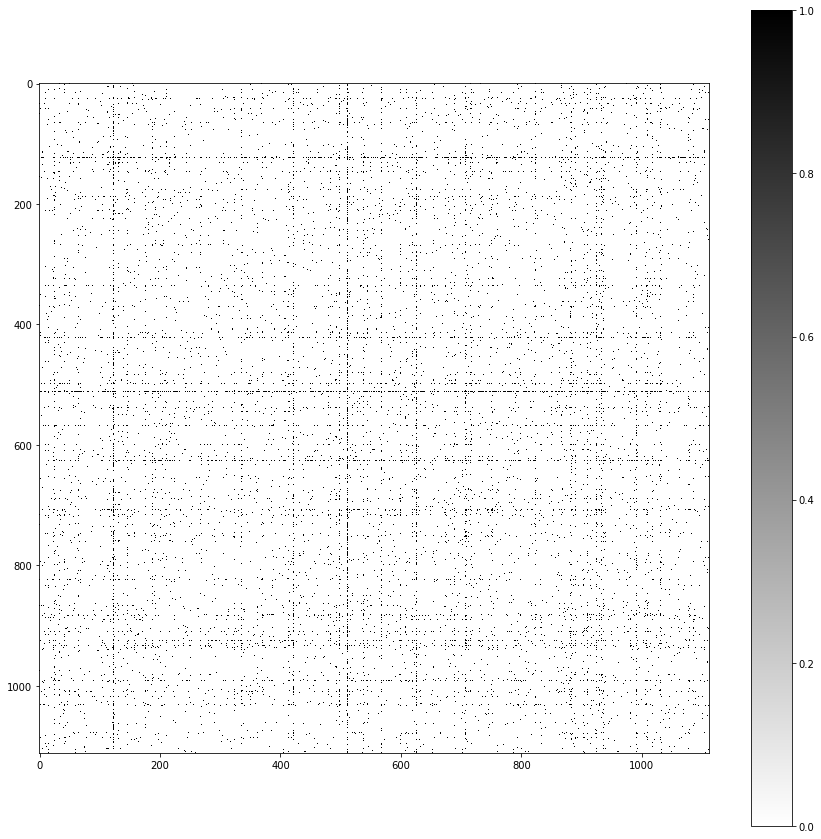

In [16]:
# Plot matrix heatmap
fig, ax = plt.subplots(figsize=(15, 15))
_ = plt.imshow(X, cmap='binary')
_ = plt.colorbar()
_ = plt.show()